<a href="https://colab.research.google.com/github/Mario-RJunior/olist-e-commerce/blob/master/time_series_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Análise Temporal

Nesta etapa do trabalho estaremos focados em estudar sobre a sazonalidade e as tendências das compras online e para isso faremos uma análise utilizando as séries temporais correspondentes. Assim, nosso primeiro passo é importar as bibliotecas a serem utilizadas e carregar os dados que precisaremos para tal análise.

### 1) Importando e carregando os dados

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from fbprophet import Prophet
from datetime import datetime, date

In [2]:
! git clone https://github.com/Mario-RJunior/olist-e-commerce

Cloning into 'olist-e-commerce'...
remote: Enumerating objects: 171, done.
remote: Counting objects: 100% (171/171), done.
remote: Compressing objects: 100% (171/171), done.
remote: Total 551 (delta 97), reused 0 (delta 0), pack-reused 380
Receiving objects: 100% (551/551), 37.48 MiB | 18.66 MiB/s, done.
Resolving deltas: 100% (325/325), done.


Inicialmente iremos selecionar as colunas que iremos utilizar e a seguir agrupá-las para gerar o dataframe.

In [3]:
# Selecionando as colunas para uso
orders_col = ['order_id', 'order_purchase_timestamp']
orders_items_col = ['order_id', 'price']

In [4]:
# Carregando os datasets
orders = pd.read_csv('olist-e-commerce/datasets/olist_orders_dataset.csv', 
                     usecols=orders_col)
orders_items = pd.read_csv('olist-e-commerce/datasets/olist_order_items_dataset.csv', 
                           usecols=orders_items_col)

In [5]:
# Junção dos dataframes
df = pd.merge(right=orders_items,
             left=orders,
             on='order_id')

In [6]:
df.head()

,order_id,order_purchase_timestamp,price
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,29.99
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,118.70
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,159.90
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,45.00
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,19.90


### 2) Verificando a consistência dos dados

In [7]:
df.shape

(112650, 3)

- Verificando os tipos das variáveis.

In [8]:
# Tipo das variáveis
df.dtypes

order_id                     object
order_purchase_timestamp     object
price                       float64
dtype: object

Agora, como desejamos trabalhar com séries temporais devemos então converter as respectivas colunas para o formato *datetime*, uma vez que elas estão originalmente no formato *object*.

In [9]:
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

Uma vez convertidas para datetime iremos fazer mais um tratamento, sobretudo na coluna "order_purchase_timestamp". Primeiramente iremos pegar apenas a data (desconsiderando a hora da compra) para depois gerar uma nova data com o dia 1 em todas elas. O motivo para isso é agruparmos mais facilmente as datas por ano e mês.

***Importante***: Apesar de termos uma time series diária ela não é contínua, ou seja, há dias em que não houve compras e portanto tais dias não aparecem registrados. Desta forma faremos nossa análise contabilizando todas as compras mensalmente.

In [10]:
# Pegando apenas a data da coluna "order_purchase_timestamp"
df['order_purchase_timestamp'] = df['order_purchase_timestamp'].apply(lambda x: x.date())

# Editando a coluna "order_purchase_timestamp" para agrupar por ano e mês
df['order_purchase_timestamp'] = df['order_purchase_timestamp'].apply(lambda x: datetime(x.year, x.month, 1))

In [11]:
# Confirmando os tipos de dados
df.dtypes

order_id                            object
order_purchase_timestamp    datetime64[ns]
price                              float64
dtype: object

In [12]:
# Verificando a existência de valores nulos
df.isnull().sum()

order_id                    0
order_purchase_timestamp    0
price                       0
dtype: int64

### 3) Explorando e tratando a base de dados

In [13]:
# Verificando as datas da primeira e da última compra
print('Data mínima: {} \nData máxima: {}'.format(df['order_purchase_timestamp'].min(), 
                                                 df['order_purchase_timestamp'].max()))

Data mínima: 2016-09-01 00:00:00 
Data máxima: 2018-09-01 00:00:00


In [14]:
df.groupby([df['order_purchase_timestamp'].dt.year,
           df['order_purchase_timestamp'].dt.month]).count()['order_id']

order_purchase_timestamp  order_purchase_timestamp
2016                      9                              6
                          10                           363
                          12                             1
2017                      1                            955
                          2                           1951
                          3                           3000
                          4                           2684
                          5                           4136
                          6                           3583
                          7                           4519
                          8                           4910
                          9                           4831
                          10                          5322
                          11                          8665
                          12                          6308
2018                      1                           8208
     

Note que no ano de 2016 temos alguns valores que não apresentam-se coerentes com o restante dos meses. Portanto iremos desconsiderar tais valores e criar o modelo utilizando todo o ano de 2017 e os nove meses de 2018.

Note ainda que do resultado acima é possível perceber que os dados referentes a 2016 somam 370 registros. Logo, iremos ordernar estas datas, criar uma lista com os índices de todos os 370 registros e deletar tais linhas.

In [15]:
# Criando uma lista com os índices
ano_2016_index = df['order_purchase_timestamp'].sort_values().index[:370]
ano_2016_index

Int64Index([ 34802,   5085,   5086,  34804,  34803,   4925, 100754, 100753,
             36654,  96214,
            ...
             18880,  73435,  60586,  14693,  64930,  28015,  22076,  64929,
             27947,  45006],
           dtype='int64', length=370)

In [16]:
# Excluindo estas linhas
df.drop(index=ano_2016_index, inplace=True)

In [17]:
# Fazendo uma nova verificação
df.groupby([df['order_purchase_timestamp'].dt.year,
           df['order_purchase_timestamp'].dt.month]).count()['order_id']

order_purchase_timestamp  order_purchase_timestamp
2017                      1                            955
                          2                           1951
                          3                           3000
                          4                           2684
                          5                           4136
                          6                           3583
                          7                           4519
                          8                           4910
                          9                           4831
                          10                          5322
                          11                          8665
                          12                          6308
2018                      1                           8208
                          2                           7672
                          3                           8217
                          4                           7975
     

### 4) Plotando comportamento das séries temporais

Agora, iremos definir duas bases de dados:

1) Considerando a quantidade de produtos que foram vendidos por mês.

2) Considerando o valor obtido por mês.

A seguir, iremos fazer um gráfico para cada situação para entender o comportamento das séries em ambos os casos.

- Plotando os dados para a quantidade de produtos vendidos mensalmente

In [18]:
# Criando o dataframe da quantidade
df_group_quant = df.groupby([df['order_purchase_timestamp'].dt.year,
           df['order_purchase_timestamp'].dt.month]).count()['order_id']

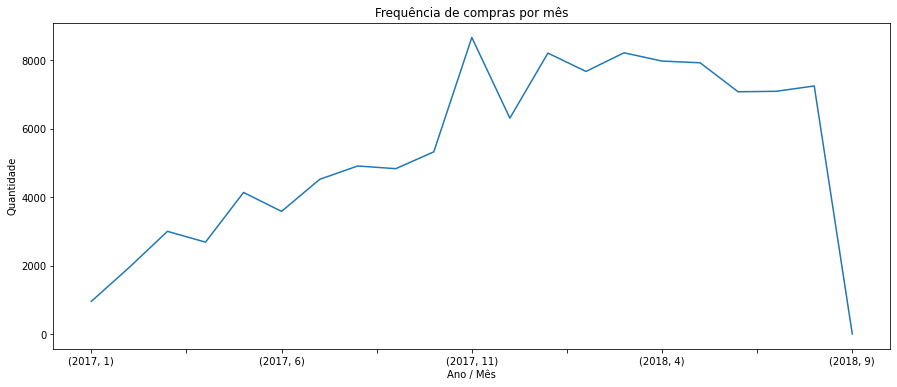

In [19]:
df_group_quant.plot(figsize=(15,6))
plt.title('Frequência de compras por mês')
plt.xlabel('Ano / Mês')
plt.ylabel('Quantidade')
plt.show()

- Plotando os dados para o total de dinheiro arrecadado pelas vendas mensalmente

In [20]:
df_group_price = df.groupby([df['order_purchase_timestamp'].dt.year,
           df['order_purchase_timestamp'].dt.month]).sum()['price']

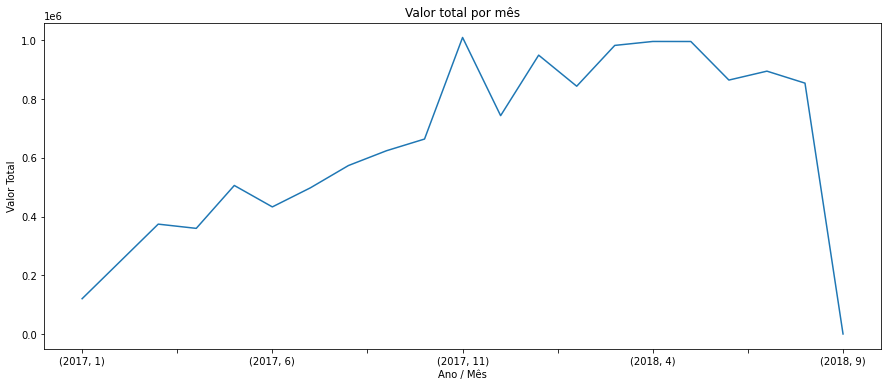

In [21]:
df_group_price.plot(figsize=(15,6))
plt.title('Valor total por mês')
plt.xlabel('Ano / Mês')
plt.ylabel('Valor Total')
plt.show()

### 5) Fazendo o forecast e analisando tendência e sazonalidade

- Criação do modelo usando o Prophet

Nesta etapa iremos utilizar a biblioteca fbprophet para gerar um modelo com o intuito de encontrar sazonalidade, tendência e fazer algumas previsões para compras nos meses futuros.

A seguir, precisaremos criar um dataframe apropriado para utilização do Prophet em ambos os casos.

In [22]:
# Criação do modelo
model_quant = Prophet(yearly_seasonality=True)
model_preco = Prophet(yearly_seasonality=True)

- Criando os respectivos dataframes

1) Considerando a quantidade de vendas

In [23]:
# Criação do dataframe das quantidades
ts_quant = df.groupby('order_purchase_timestamp').count()['order_id'].reset_index()
ts_quant.rename(columns= {
    'order_purchase_timestamp': 'ds',
    'order_id': 'y'
    }, inplace=True)
ts_quant.head()

,ds,y
0,2017-01-01,955
1,2017-02-01,1951
2,2017-03-01,3000
3,2017-04-01,2684
4,2017-05-01,4136


2) Considerando o preço total das vendas

In [24]:
# Criando o dataframe do valor total das vendas
ts_preco = df.groupby('order_purchase_timestamp').sum()['price'].reset_index()
ts_preco.rename(columns= {
    'order_purchase_timestamp': 'ds',
    'price': 'y'
    }, inplace=True)
ts_preco.head()

,ds,y
0,2017-01-01,120312.87
1,2017-02-01,247303.02
2,2017-03-01,374344.30
3,2017-04-01,359927.23
4,2017-05-01,506071.14


- Treinando o modelo e fazendo a previsão

Agora, iremos fazer o treinamento para os dois casos acima e a seguir fazer as respectivas previsões.

1) Considerando a quantidade de vendas

In [25]:
# Fazendo o treinamento
model_quant.fit(ts_quant)

# Criando um dataframe para dados futuros
future_quant = model_quant.make_future_dataframe(periods = 5, freq = 'MS')

# Fazendo a previsão
forecast_quant = model_quant.predict(future_quant)
forecast_quant[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


,ds,yhat,yhat_lower,yhat_upper
21,2018-10-01,29958.690820,29957.597473,29959.556032
22,2018-11-01,12171.298250,12167.586374,12174.636276
23,2018-12-01,-5150.668780,-5157.634045,-5144.074151
24,2019-01-01,15916.895847,15905.465201,15927.182441
25,2019-02-01,13639.161844,13622.313233,13653.474476


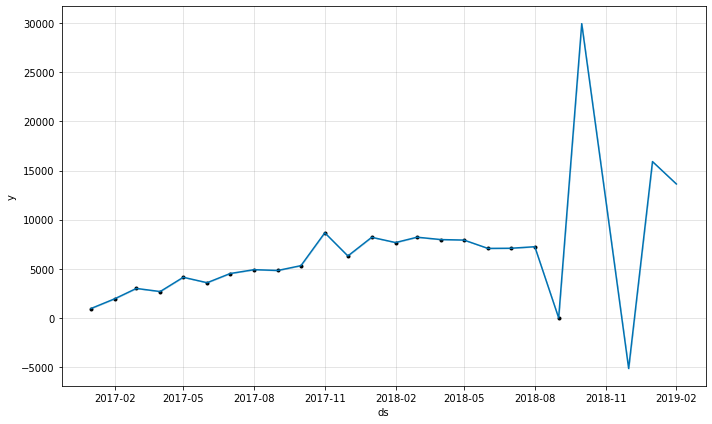

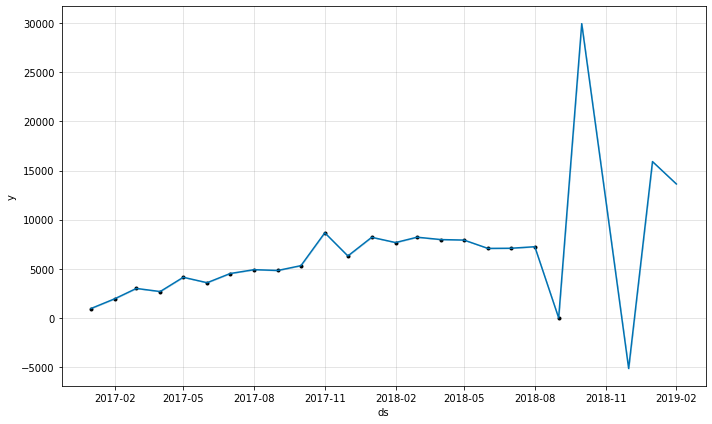

In [26]:
# Plotando o gráfico das previsões
model_quant.plot(forecast_quant)

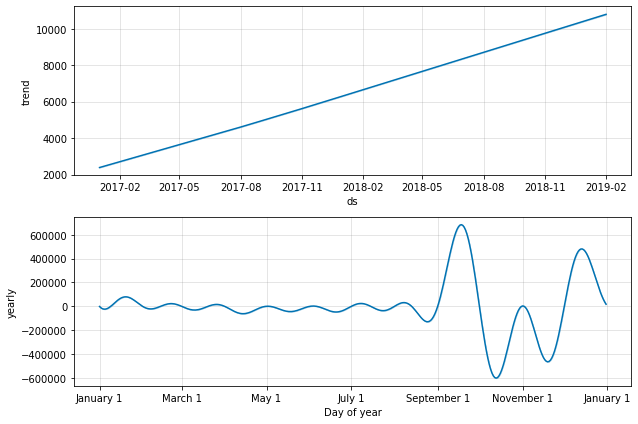

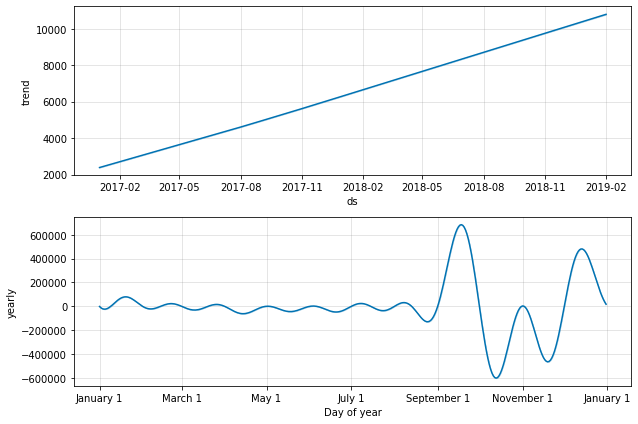

In [27]:
# Plotando os gráficos de tendência
model_quant.plot_components(forecast_quant)

2) Considerando o preço total das vendas

In [28]:
# Fazendo o treinamento
model_preco.fit(ts_preco)

# Criando um dataframe para dados futuros
future_preco = model_preco.make_future_dataframe(periods = 5, freq = 'MS')

# Fazendo a previsão
forecast_preco = model_preco.predict(future_preco)
forecast_preco[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


,ds,yhat,yhat_lower,yhat_upper
21,2018-10-01,4.209729e+06,4.206993e+06,4.211746e+06
22,2018-11-01,7.387272e+05,7.291383e+05,7.476231e+05
23,2018-12-01,3.555495e+05,3.377112e+05,3.750397e+05
24,2019-01-01,1.989881e+06,1.960227e+06,2.022329e+06
25,2019-02-01,1.712286e+06,1.670621e+06,1.758505e+06


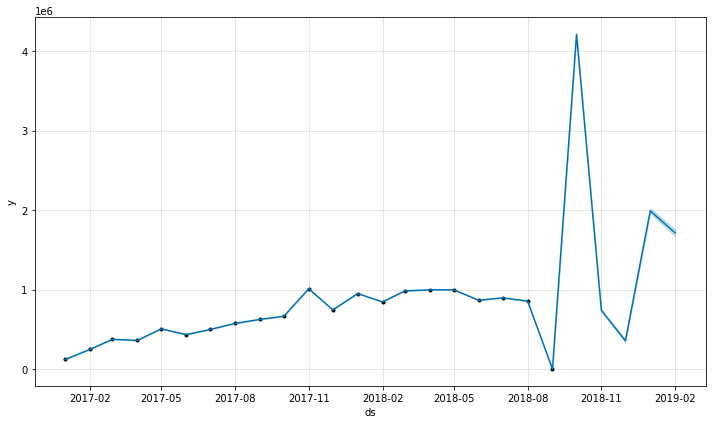

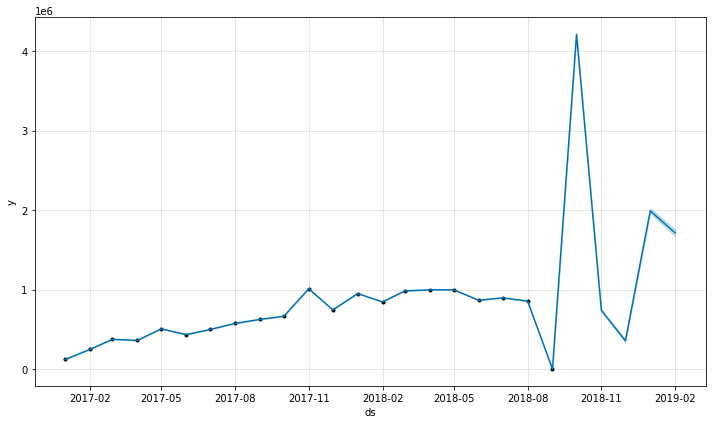

In [29]:
# Plotando o gráfico das previsões
model_preco.plot(forecast_preco)

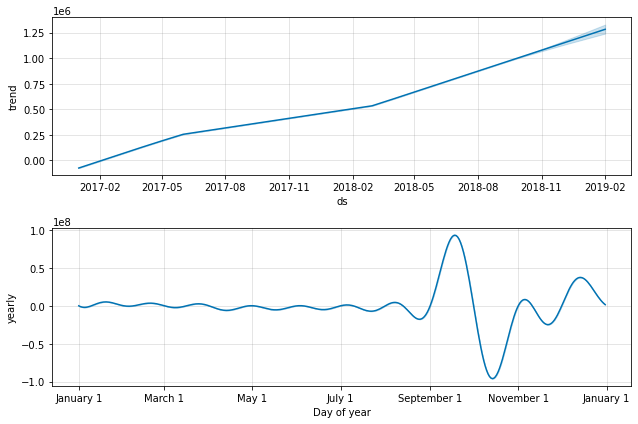

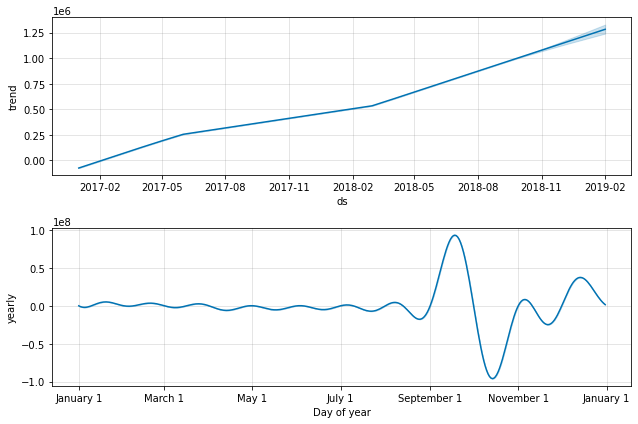

In [30]:
# Plotando os gráficos de tendência
model_preco.plot_components(forecast_preco)